# Pytorch3D Tutorial

Contents of tutorial:
* Installing Pytorch3D on Colab
* Mesh Rendering
* Point cloud Rendering

More tutorials available: https://github.com/facebookresearch/pytorch3d

## Installing Pytorch3D


It will be much faster if you switch to GPU runtime (Runtime > Change runtime type > Hardware Accelerator > GPU).

In [83]:
import os
import sys
import torch

# Suppress scientific notation
torch.set_printoptions(sci_mode=False)

# Install PyTorch3D if necessary
need_pytorch3d=False

try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True

if need_pytorch3d:
    !uv pip install --extra-index-url https://miropsota.github.io/torch_packages_builder pytorch3d==0.7.8+pt{torch.__version__.replace('+', '')}

In [84]:
!pwd

/content


In [85]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch3d
import pytorch3d.io
from pytorch3d.vis.plotly_vis import plot_scene
from tqdm.auto import tqdm

In [86]:
# This should print True if you are using your GPU
print("Using GPU:", torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Using GPU: True


## Rendering a Mesh

To render a mesh, we need 3 components:

* A mesh to render
* A camera to render from
* A renderer (consisting of a rasterizer and shader)

### Setting up a mesh

Take an examble object data/cow.obj

In this file you will see 4 data types:

1.   mtllib cow.mtl : This tells OBJ which MTL file to load.
2.   v 0.10 0.20 0.30 : Lines starting with ```v``` hold vertex positions.
2.   vt 0.50 0.75 : Lines starting with ```vt``` hold texture coordinates.
1.   f 1/1 2/2 3/3  : Lines starting with ```f``` hold faces.

Each face entry gives vertex, texture index, and optional normal index.
```
faces.verts_idx → vertex indices
faces.textures_idx → uv indices
```




In [87]:
vertices, face_props, text_props = pytorch3d.io.load_obj("data/cow.obj")
faces = face_props.verts_idx

In [88]:
print("Vertices", vertices.shape)
print("Faces", faces.shape)

Vertices torch.Size([2930, 3])
Faces torch.Size([5856, 3])


In [89]:
print("vertices: ", vertices[0])
print("faces: ", faces[0])

faces.min(), faces.max()

vertices:  tensor([ 0.3488, -0.3350, -0.0832])
faces:  tensor([738, 734, 735])


(tensor(0), tensor(2929))

In [90]:
# All Pytorch3D elements need to be batched!
vertices = vertices.unsqueeze(0)  # 1 x num_vertices x 3
faces = faces.unsqueeze(0)        # 1 x num_faces x 3

print("Vertices", vertices.shape)
print("Faces", faces.shape)

Vertices torch.Size([1, 2930, 3])
Faces torch.Size([1, 5856, 3])


In [91]:
texture_rgb = torch.ones_like(vertices) # N X 3
texture_rgb = texture_rgb * torch.tensor([0.7, 0.7, 1])

# Wrap the colors as vertex textures
textures = pytorch3d.renderer.TexturesVertex(texture_rgb) # Manually created, did't used the cow.mtl file
print(texture_rgb)
print(texture_rgb.shape)

tensor([[[0.7000, 0.7000, 1.0000],
         [0.7000, 0.7000, 1.0000],
         [0.7000, 0.7000, 1.0000],
         ...,
         [0.7000, 0.7000, 1.0000],
         [0.7000, 0.7000, 1.0000],
         [0.7000, 0.7000, 1.0000]]])
torch.Size([1, 2930, 3])


In [92]:
meshes = pytorch3d.structures.Meshes(
    verts=vertices, # batched tensor or a list of tensors
    faces=faces,
    textures=textures,
)
meshes = meshes.to(device)  # Move mesh to GPU

In [93]:
print(meshes.verts_padded().shape)
print(meshes.faces_padded().shape)

torch.Size([1, 2930, 3])
torch.Size([1, 5856, 3])


### Setting up a camera

In [94]:
R = torch.eye(3).unsqueeze(0)   # identity rotation
T = torch.tensor([[0, 0, 3]])   # camera at z=3

In [95]:
# world -> view transforms
# view_T_world @ world = view

cameras = pytorch3d.renderer.FoVPerspectiveCameras(
    R=R,
    T=T,
    fov=60,
    device=device,
)

# FoVPerspectiveCameras uses R and T: view_point = R * world_point + T

In [96]:
cameras.get_camera_center()  # returns the camera location in world space.

# Since we have identity rotation and T moves the whole world by +3 in camera space, this is simply -T.

tensor([[ 0.,  0., -3.]], device='cuda:0')

In [97]:
transform = cameras.get_world_to_view_transform()  # gives the final world to view matrix.
transform.get_matrix()

tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 3., 1.]]], device='cuda:0')

This shifts the world by +3 along z in view space, which is the same as placing the camera at z = -3.

### Setting up a Renderer

Rasterizer: Given a pixel, which triangles correspond to it?

Shader: Given triangle, texture, lighting, etc, how should the pixel be colored?

In [98]:
image_size = 512

raster_settings = pytorch3d.renderer.RasterizationSettings(image_size=image_size) # other params like blur, faces per pixel are default
rasterizer = pytorch3d.renderer.MeshRasterizer(
    raster_settings=raster_settings,
)
shader = pytorch3d.renderer.HardPhongShader(device=device)  # applies lighting, shading - output RGBA
renderer = pytorch3d.renderer.MeshRenderer(
    rasterizer=rasterizer,
    shader=shader,
)  # a wrapper that first calls rasterizer(meshes, cameras) and shader (lights)

### Render an image

In [99]:
image = renderer(meshes, cameras=cameras)
print(image.shape)

torch.Size([1, 512, 512, 4])


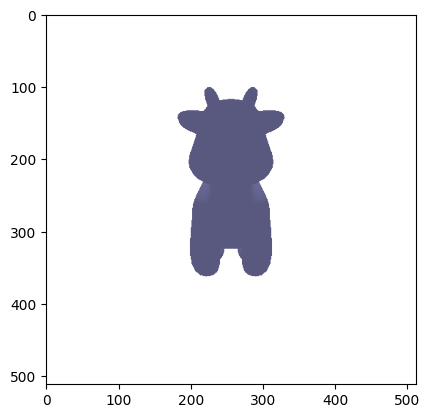

In [100]:
image = image[0].cpu().numpy()
plt.imshow(image)

In [101]:
print(image.min(), image.max())

0.0 1.0


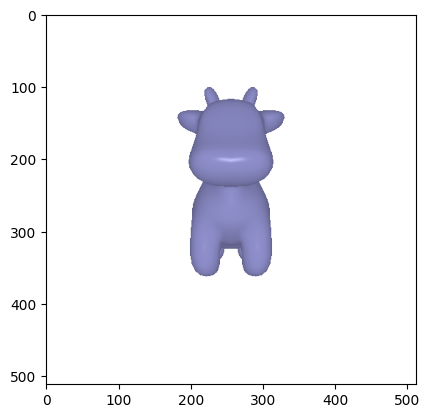

In [102]:
# Lets add some lights to our image

lights = pytorch3d.renderer.PointLights(location=[[0, 0, -3]], device=device) # light at the same location as camera
image = renderer(meshes, cameras=cameras, lights=lights)
plt.imshow(image[0].cpu().numpy())

In [103]:
plot_scene({
    "figure": {
        "Mesh": meshes,
        "Camera": cameras,
    }
})

# plot_scene does not show the rendered image from the shader. It shows the scene layout.

### Common Rendering Problems

* Nothing is visible
    * Check Camera center
    * Check the Camera world_to_view transform. Try applying the transform to the origin or specific vertices of the mesh.
    * Use the Plotly visualization.
* Lights doesn't seem to do anything
    * Make sure there's no typo (must be `renderer(..., lights=lights)` and not `light=lights`)
    * Check the position of the light



### Transformations

2 ways to apply geometric operations:
* Move the mesh
* Move the camera

In [104]:
relative_rotation = pytorch3d.transforms.euler_angles_to_matrix(
    torch.tensor([0, np.pi/2, 0]), "XYZ"
)
relative_rotation  # rotation of 90 degrees around the Y axis

tensor([[    -0.0000,      0.0000,      1.0000],
        [     0.0000,      1.0000,      0.0000],
        [    -1.0000,      0.0000,     -0.0000]])

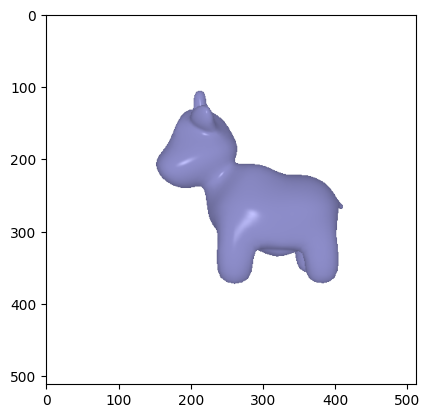

In [105]:
meshes2 = pytorch3d.structures.Meshes(
    verts=vertices @ relative_rotation,
    faces=faces,
    textures=textures,
).to(device)

# build a new mesh where each vertex p is mapped to p' = p R, with R = relative_rotation.

image = renderer(meshes2, cameras=cameras, lights=lights)
plt.imshow(image[0].cpu().numpy())

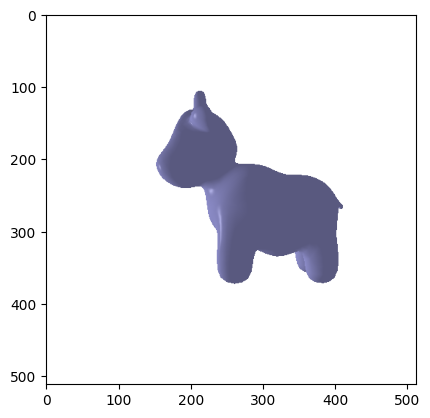

In [106]:
# Same output can be expected with the camera rotation

cameras2 = pytorch3d.renderer.FoVPerspectiveCameras(
    R=relative_rotation.unsqueeze(0),
    T=[[0, 0, 3]],
    device=device
)

image = renderer(meshes, cameras=cameras2, lights=lights)
plt.imshow(image[0].cpu().numpy())

In [107]:
transform = cameras2.get_world_to_view_transform()
transform.get_matrix()

tensor([[[    -0.0000,      0.0000,      1.0000,      0.0000],
         [     0.0000,      1.0000,      0.0000,      0.0000],
         [    -1.0000,      0.0000,     -0.0000,      0.0000],
         [     0.0000,      0.0000,      3.0000,      1.0000]]],
       device='cuda:0')

In [108]:
plot_scene({
    "Mesh1": {
        "Mesh": meshes,
        "Camera1": cameras,
        "Camera2": cameras2,
    },
    "Mesh2": {
        "Mesh": meshes2,
        "Camera1": cameras,
        "Camera2": cameras2,
    },
}, ncols=2)

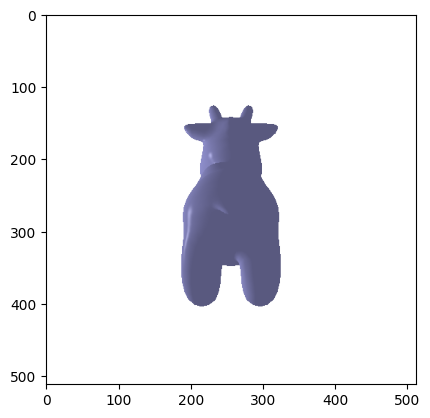

In [109]:
image = renderer(meshes2, cameras=cameras2, lights=lights)
plt.imshow(image[0].cpu().numpy())

In [110]:
num_views = 12
R, T = pytorch3d.renderer.look_at_view_transform(
    dist=3,
    elev=0,
    azim=np.linspace(-180, 180, num_views, endpoint=False),
)

# dist=3 places every camera on a circle of radius 3 around the origin
# elev=0 keeps them on the horizontal plane
# azim is an array of 12 angles from -180 to 180 degrees

print("R", R.shape)
print("T", T.shape)
many_cameras = pytorch3d.renderer.FoVPerspectiveCameras(
    R=R,
    T=T,
    device=device
)

# This builds a batch of 12 perspective cameras, one per view
images = renderer(meshes.extend(num_views), cameras=many_cameras, lights=lights)

R torch.Size([12, 3, 3])
T torch.Size([12, 3])


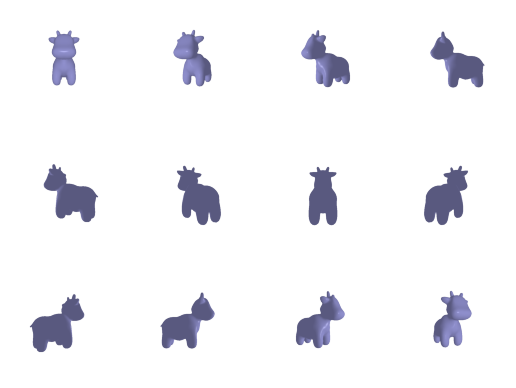

In [111]:
fig, axs = plt.subplots(3, 4)
axs = axs.flatten()
for i, image in enumerate(images):
    ax = axs[i]
    ax.imshow(image.cpu())
    ax.axis("off")

In [112]:
plot_scene({
    "All Views": {
        "Mesh": meshes,
        "Cameras": many_cameras,
    },
})

### Playing with Texture

In [113]:
texture_rgb = vertices.clone()
texture_rgb = (texture_rgb - texture_rgb.min()) / (texture_rgb.max() - texture_rgb.min())
texture_rgb /= texture_rgb.norm(dim=2, keepdim=True)
textures_rainbow = pytorch3d.renderer.TexturesVertex(texture_rgb.to(device))
meshes.textures = textures_rainbow

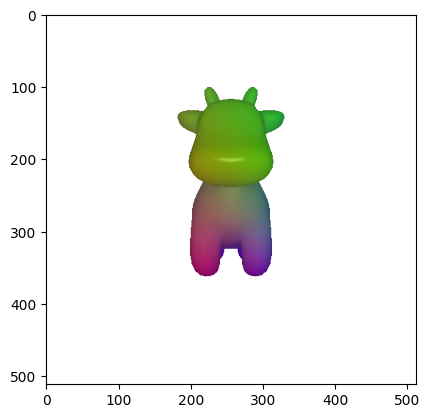

In [114]:
image = renderer(meshes, cameras=cameras, lights=lights)
plt.imshow(image[0].cpu().numpy())

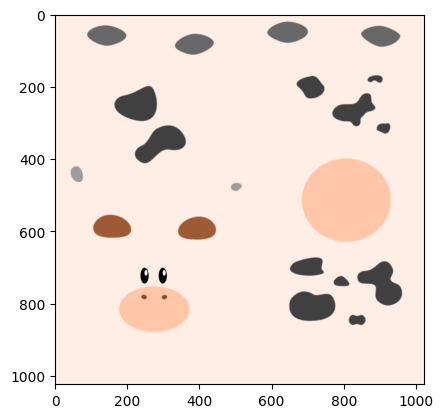

In [115]:
vertices, face_props, text_props = pytorch3d.io.load_obj("data/cow.obj")
faces = face_props.verts_idx
vertices = vertices.unsqueeze(0)  # [1, V, 3]
faces = faces.unsqueeze(0)        # [1, F, 3]
verts_uvs = text_props.verts_uvs
faces_uvs = face_props.textures_idx

texture_map = plt.imread("data/cow_texture.png")
plt.imshow(texture_map)

In [116]:
textures_uv = pytorch3d.renderer.TexturesUV(
    maps=torch.tensor([texture_map]),
    faces_uvs=faces_uvs.unsqueeze(0),
    verts_uvs=verts_uvs.unsqueeze(0),
).to(device)

/tmp/ipython-input-2245936011.py:2: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)



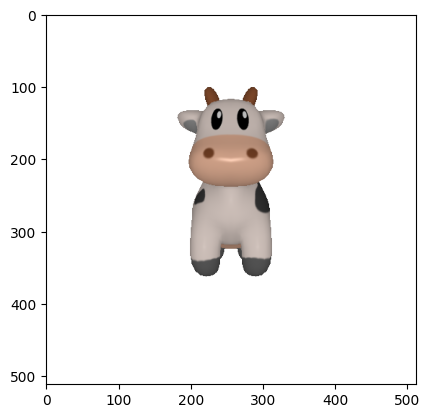

In [117]:
meshes.textures = textures_uv
image = renderer(meshes, cameras=cameras, lights=lights)
plt.imshow(image[0].cpu().numpy())

## Rendering Pointclouds

We will need:

* A point cloud
* A camera
* A point renderer

### Setting up Point Cloud

In [118]:
coords = torch.randn(1000, 3)
rgb = torch.ones_like(coords) * torch.tensor([0.7, 0.7, 1])

print("Coords:", coords.shape)
print("RGB:", rgb.shape)

Coords: torch.Size([1000, 3])
RGB: torch.Size([1000, 3])


In [119]:
pointcloud = pytorch3d.structures.Pointclouds(
    points=coords.unsqueeze(0),
    features=rgb.unsqueeze(0),
).to(device)

In [120]:
raster_settings = pytorch3d.renderer.PointsRasterizationSettings(
image_size=512,
radius=0.01,
)

rasterizer = pytorch3d.renderer.PointsRasterizer(
cameras=cameras,
raster_settings=raster_settings,
)

renderer = pytorch3d.renderer.PointsRenderer(rasterizer=rasterizer,
compositor=pytorch3d.renderer.AlphaCompositor(background_color=(1, 1, 1),)
)

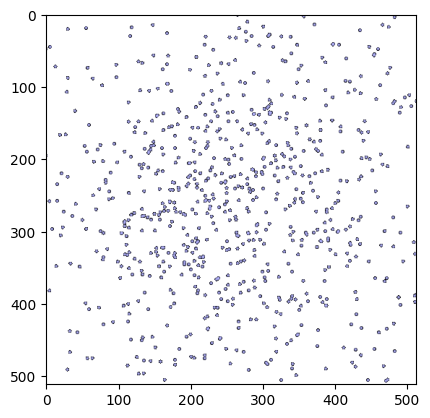

In [121]:
image = renderer(pointcloud, cameras=cameras)
plt.imshow(image[0].cpu())

In [122]:
plot_scene({
    "Pointcloud": {
        "Pointcloud": pointcloud,
        "Camera": cameras,
    },
})

In [123]:
rgb = coords.clone()
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

pointcloud = pytorch3d.structures.Pointclouds(
    points=coords.unsqueeze(0),
    features=rgb.unsqueeze(0),
).to(device)

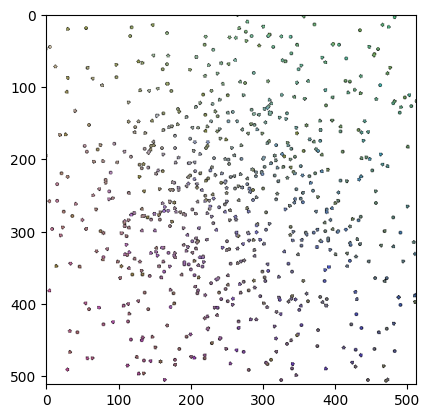

In [124]:
image = renderer(pointcloud, cameras=cameras)
plt.imshow(image[0].cpu())

### Rendering Parametric Functions

Equation of a sphere with radius $r$ with center $(x_0, y_0, z_0)$:

$$x = x_0 + r * \sin \theta \cos\phi$$
$$y = y_0 + r * \cos \theta $$
$$z = z_0 + r * \sin\theta \sin\phi$$

In [125]:
num_samples = 1000
r = 1
x_0 = 0
y_0 = 0
z_0 = 0

phi = torch.linspace(0, np.pi, num_samples)
theta = torch.linspace(0, 2 * np.pi, num_samples)
Phi, Theta = torch.meshgrid(phi, theta, indexing="ij")

# Theta as polar and Phi as azimuth
print("Phi", Phi.shape)
print("Theta", Theta.shape)

Phi torch.Size([1000, 1000])
Theta torch.Size([1000, 1000])


In [126]:
x = x_0 + r * torch.sin(Theta) * torch.cos(Phi)
y = y_0 + r * torch.cos(Theta)
z = z_0 + r * torch.sin(Theta) * torch.sin(Phi)

In [127]:
points = torch.stack((x.flatten(), y.flatten(), z.flatten()), dim=1)
color = (points - points.min()) / (points.max() - points.min())

sphere_point_cloud = pytorch3d.structures.Pointclouds(
    points=[points], features=[color],
).to(device)

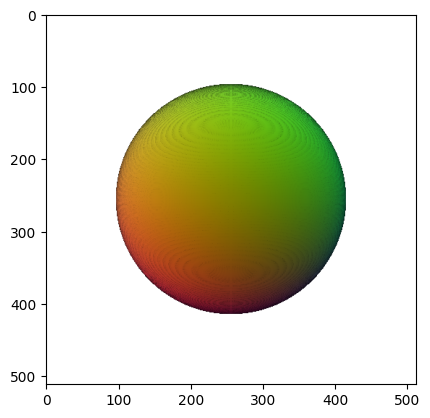

In [128]:
image = renderer(sphere_point_cloud, cameras=cameras)
plt.imshow(image[0].cpu())

In [129]:
plot_scene({
    "Pointcloud": {
        "Pointcloud": sphere_point_cloud,
        "Camera": cameras,
    },
})